# **Описание**

Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице  
2	Средняя длинна слова  
3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)  
4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)  
5	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://kaggle.com/join/antispam_infopoisk  
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ  

Описание ДЗ и правил выставления за него баллов в https://inclass.kaggle.com/c/antispam-infopoisk   
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import sys
import numpy as np

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

# Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [257]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False
        self._anchor = []
        self._in_anchor = False
        self._links_number = "1"# костылище
        self._image_number = "1"
        self._script_number = "1"
        self._css = "1"

    def handle_data(self, data):
        text = data.strip()
        if self._in_title:
            self._title = text
            self._in_title = False
        elif self._in_anchor:
            self._anchor.append(text + ' ')
            self._in_anchor = False
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')          

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'a':
            self._in_anchor = True
            self._links_number += "1"
        elif tag == "img":
            self._image_number += "1"
        elif tag == "script":
            self._script_number += "1"
            

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')
        elif tag == "link":
            self._css += "1"

    def text(self):
        return ''.join(self._text).strip()
    
    def title(self):
        return ''.join(self._title).strip()
    
    def anchor(self):
        return ''.join(self._anchor).strip()
    
    def links_number(self):
        return ''.join(self._links_number).strip()
    
    def image_number(self):
        return ''.join(self._image_number).strip()
    
    def script_number(self):
        return ''.join(self._script_number).strip()
    
    def css_number(self):
        return ''.join(self._css).strip()
        
@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return {"title" : parser.title(), 
            "anchor": parser.anchor(), 
            "text" : parser.text(), 
            "links_number": parser.links_number(),
            "image_number": parser.image_number(),
            "script_number": parser.script_number(),
            "css": parser.css_number()
           }

#### Извлечение текста при помощи дополнительных библиотек

In [258]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [259]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [260]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [261]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    # to_text(raw_html) is a dict
    return dict(map(lambda x: (x[0], list(tokenizer(x[1].lower()))), to_text(raw_html).iteritems()))

#### Рассчет финальных метрик

In [262]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

# FEARURES FUNCTION IS HERE
# FEARURES FUNCTION IS HERE
# FEARURES FUNCTION IS HERE

In [263]:
# dict keys: ['text', 'anchor', 'title']
def calc_features(url, html_data, comp_level = 0):
    dict_data = html2word(html_data)
#     print "dict keys: " + str(dict_data.keys())
    
    words_num = len(dict_data["text"])
    avg_word_len = np.mean([len(word) for word in dict_data["text"]])
    title_words_num = len(dict_data["title"]) 
    anchor_words_num = len(dict_data["anchor"])
    links_number = len(dict_data["links_number"][0]) - 1 #костыль
    image_number = len(dict_data["image_number"][0]) - 1
    script_number = len(dict_data["script_number"][0]) - 1
    css_number = len(dict_data["css"][0]) - 1

    compression_level = comp_level
    url_len = len(url)
    dot_html_exist = 0 if url[-6:].find("html")== -1 else 1
    dot_in_url_count = url.count(".")
    slash_number_count = url.count("/")
    
    return [words_num, #0
            avg_word_len, #1
            title_words_num, #2 
            anchor_words_num, #3
            compression_level, #4
            url_len, #5
            dot_html_exist, #6 присутствие чтмл
            dot_in_url_count, #7 кол-во точек в урле
            links_number, #8 число ссылок (анкоров)
            slash_number_count, #9 число слешей
            image_number, #10 число картинок
            script_number, #11 количество джаваскрипта
            css_number
           ]

In [264]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
<a> &copy; Some text </a>
<a> Another text </a>
<script type="text/javascript" src="js-file.js"></script>
<link rel="stylesheet" type="text/css" href="mystyles.css" media="screen" />
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print test_features

[10, 4.0, 2, 2, 0, 12, 0, 0, 2, 2, 0, 1, 1]


In [265]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
#             print sys.getsizeof(pageInb64)
#             print sys.getsizeof(html_data)
#             print len(pageInb64)
#             print len(html_data)
#             print
            compres_lvl = (len(pageInb64) / len(html_data) - 1.333) * 100000 - 30
            features = calc_features_f(url, html_data, compres_lvl)
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)        

In [266]:
DocItem_h = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'html_data'])

def load_html(input_file_name):    
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            yield DocItem_h(url_id, mark, url, html_data)            
                
        trace(i, 1)

**Обрабатываем входной файл**
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [267]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

23:31:20 INFO:Complete items 00000
23:31:33 INFO:Complete items 01000
23:31:44 INFO:Complete items 02000
23:31:55 INFO:Complete items 03000
23:32:06 INFO:Complete items 04000
23:32:18 INFO:Complete items 05000
23:32:29 INFO:Complete items 06000
23:32:41 INFO:Complete items 07000
23:32:42 INFO:Complete items 07043


CPU times: user 1min 21s, sys: 284 ms, total: 1min 21s
Wall time: 1min 21s


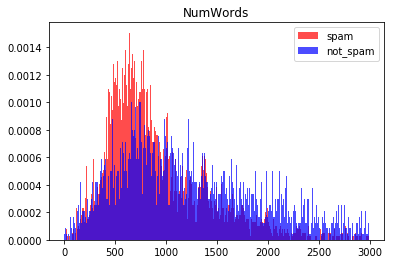

In [126]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

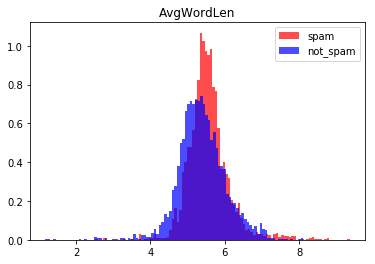

In [15]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

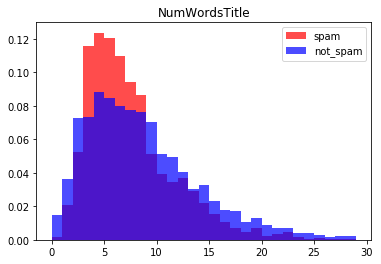

In [16]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

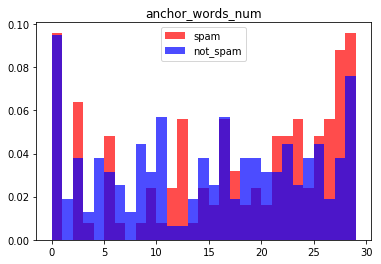

In [17]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('anchor_words_num')
plt.legend()
plt.show()

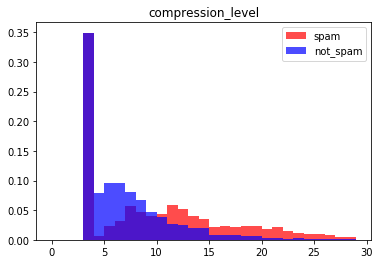

In [18]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('compression_level')
plt.legend()
plt.show()

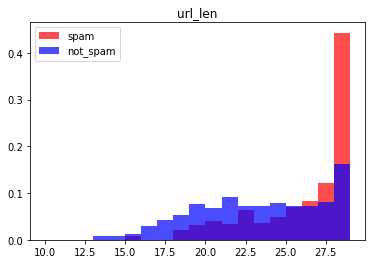

In [152]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(10, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('url_len')
plt.legend()
plt.show()

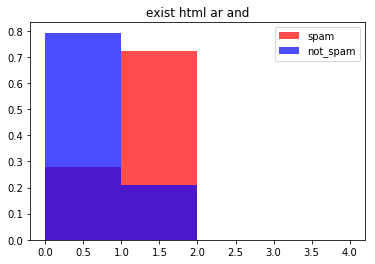

In [154]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(0, 5, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('exist html ar and')
plt.legend()
plt.show()

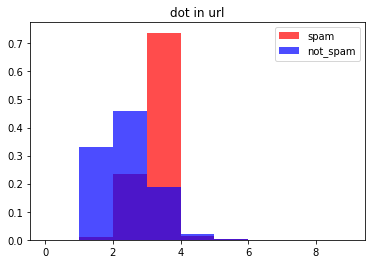

In [155]:
is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
bins = range(0, 10, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('dot in url')
plt.legend()
plt.show()

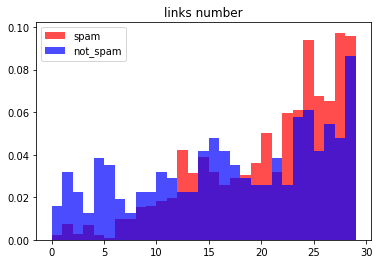

In [127]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('links number')
plt.legend()
plt.show()

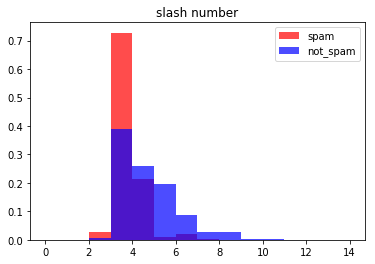

In [166]:
is_spam_data = [doc.features[9] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[9] for doc in train_docs if doc[1] == False]
bins = range(0, 15, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('slash number')
plt.legend()
plt.show()

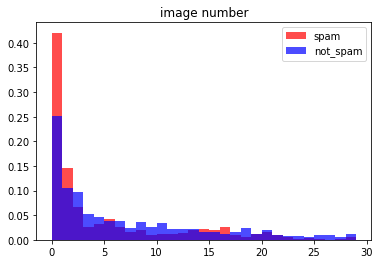

In [220]:
is_spam_data = [doc.features[10] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[10] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('image number')
plt.legend()
plt.show()

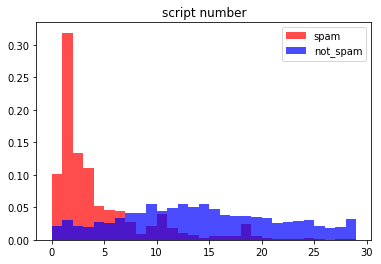

In [221]:
is_spam_data = [doc.features[11] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[11] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('script number')
plt.legend()
plt.show()

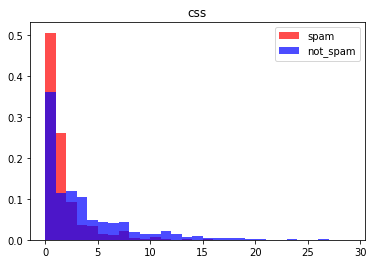

In [268]:
is_spam_data = [doc.features[12] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[12] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('css')
plt.legend()
plt.show()

In [190]:
# [words_num, avg_word_len, title_words_num, anchor_words_num, compression_level]

**Классификатор:**
Нужно реализовать

In [215]:
from sklearn.ensemble import GradientBoostingClassifier

class Classifier:
    
    def __init__(self):
        self.clf = GradientBoostingClassifier(n_estimators = 1000)

    def predict(self, doc):
        features = np.array([doc.features])
        features = np.nan_to_num(features)
        return self.clf.predict(features)                   
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):                
#         for doc_num, doc in enumerate(docs):                            
#             #TODO вставить код обучения
#             trace(doc_num)
#         trace(doc_num, 1)
        features = np.array([doc.features for doc in docs]).astype("float32")
        targets =  np.array([doc.is_spam for doc in docs]).astype("float32")
        features = np.nan_to_num(features)
        targets = np.nan_to_num(targets)

        self.clf = self.clf.fit(features, targets)

новые  
идеи  
тут

In [269]:
classifier = Classifier()

classifier.train(train_docs)

In [270]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

array([1.], dtype=float32)

**Рисуем графики**

23:32:47 INFO:Complete items 00000
23:32:47 INFO:Complete items 01000
23:32:47 INFO:Complete items 02000
23:32:48 INFO:Complete items 03000
23:32:48 INFO:Complete items 04000
23:32:48 INFO:Complete items 05000
23:32:49 INFO:Complete items 06000
23:32:49 INFO:Complete items 07000


threshold 0
	class_prec 0.997568684658, class_recall 0.998539790703, class_F1 0.998054001459
	not_class_prec 0.997952917093, not_class_recall 0.996592844974, not_class_F1 0.99727241732
		MacroF1Mesure 0.99766320939
threshold 0.1
	class_prec 0.997568684658, class_recall 0.998539790703, class_F1 0.998054001459
	not_class_prec 0.997952917093, not_class_recall 0.996592844974, not_class_F1 0.99727241732
		MacroF1Mesure 0.99766320939
threshold 0.2
	class_prec 0.997568684658, class_recall 0.998539790703, class_F1 0.998054001459
	not_class_prec 0.997952917093, not_class_recall 0.996592844974, not_class_F1 0.99727241732
		MacroF1Mesure 0.99766320939
threshold 0.3
	class_prec 0.997568684658, class_recall 0.998539790703, class_F1 0.998054001459
	not_class_prec 0.997952917093, not_class_recall 0.996592844974, not_class_F1 0.99727241732
		MacroF1Mesure 0.99766320939
threshold 0.4
	class_prec 0.997568684658, class_recall 0.998539790703, class_F1 0.998054001459
	not_class_prec 0.997952917093, not_cla

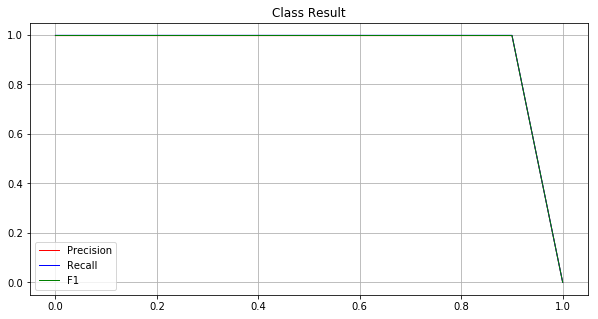

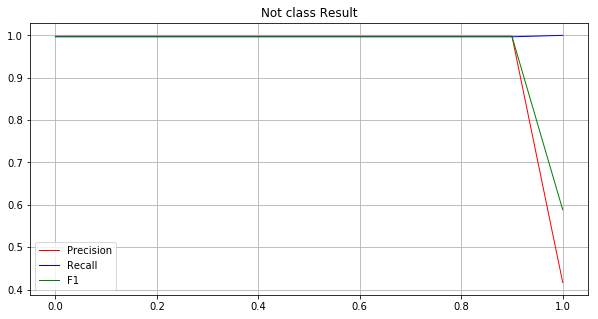

In [271]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.1, trace=1)

In [272]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv(TEST_DATA_FILE, calc_features)

threshold = 0.5

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

23:32:49 INFO:Complete items 00000
23:32:49 INFO:Complete items 00000
23:33:06 INFO:Complete items 01000
23:33:06 INFO:Complete items 01000
23:33:22 INFO:Complete items 02000
23:33:22 INFO:Complete items 02000
23:33:36 INFO:Complete items 03000
23:33:36 INFO:Complete items 03000
23:33:49 INFO:Complete items 04000
23:33:49 INFO:Complete items 04000
23:34:01 INFO:Complete items 05000
23:34:01 INFO:Complete items 05000
23:34:16 INFO:Complete items 06000
23:34:16 INFO:Complete items 06000
23:34:28 INFO:Complete items 07000
23:34:29 INFO:Complete items 07000
23:34:42 INFO:Complete items 08000
23:34:42 INFO:Complete items 08000
23:34:55 INFO:Complete items 09000
23:34:55 INFO:Complete items 09000
23:35:12 INFO:Complete items 10000
23:35:12 INFO:Complete items 10000
23:35:25 INFO:Complete items 11000
23:35:25 INFO:Complete items 11000
23:35:38 INFO:Complete items 12000
23:35:38 INFO:Complete items 12000
23:35:50 INFO:Complete items 13000
23:35:50 INFO:Complete items 13000
23:36:04 INFO:Comple